# MNIST: Reconocimiento de Ropa
## Primer Intento: Red Densa

In [13]:
from tensorflow import keras

# Cargamos los datos
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Le damos una nueva forma a los datos, indicando con la última coordenada que hay un sólo canal de color (gris)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Normalizamos
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Aplicamos one-hot encoding a las etiquetas
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [14]:
y_train.shape

(60000, 10)

In [15]:
# Ver la referencia: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data

etiquetas = ['Remera/top', 'Pantalón', 'Pullover', 'Vestido', 'Saco', 'Sandalia', 'Camisa', 'Zapatilla', 'Bolsa', 'Botines']

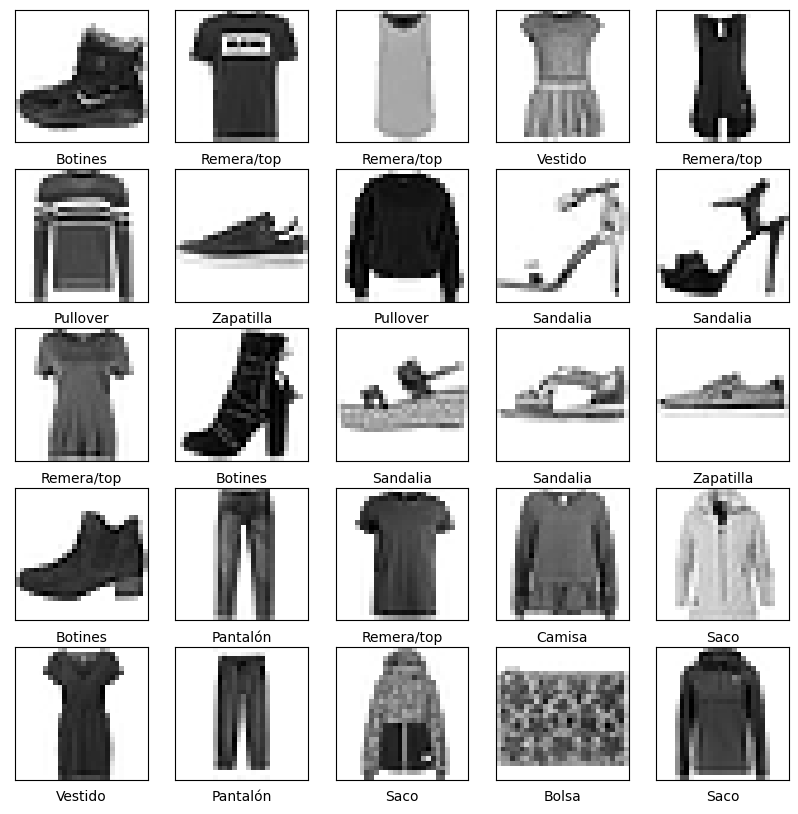

In [16]:
# Ahora sí, mostramos un par de ejemplos
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Nos armamos una grilla de 5x5 de imagenes
ALTO = 5
ANCHO = 5
TOTAL = ALTO * ANCHO

# Hacemos que el tamaño de la imagen dependa del tamaño de la grilla
plt.figure(figsize=(ANCHO*2, ALTO*2))

# Este for quedó medio feo. Pueden buscar y experimentar aparte qué hacen
#   enumerate y zip. Básicamente vamos recorriendo las imagenes y ejecutando
#   el siguiente codigo por cada una.
for i, (imagen, etiqueta) in enumerate(zip(x_train, y_train), start=1):
  # Para que pare una vez que mostró todas las imagenes
  if i > TOTAL:
    break
  
  # Seleccionamos el i-esimo cuadrado de nuestra grilla
  plt.subplot(ALTO, ANCHO, i)

  # Para mejorar un poco la estética
  plt.xticks([])
  plt.yticks([])

  # Con np.argmax convertimos el vector de outputs en un único elemento 
  #   que va a ser nuestra predicción: la posición que tiene mayor probabilidad
  #   Después usamos el array de etiquetas para convertir este número al texto orginal.
  plt.xlabel(etiquetas[np.argmax(etiqueta)])

  # Mostramos la imagen. El cmap es para que sepa cómo interpretar la escala de grises
  #   que le pasamos. Pueden ver otras paletas de colores en:
  #   https://matplotlib.org/stable/tutorials/colors/colormaps.html
  plt.imshow(imagen.reshape((28,28)), cmap='gray_r')

In [17]:
# Armamos la red densa
modelo = keras.Sequential([
    # Aplastamos la input
    keras.layers.Flatten(input_shape=(28,28,1)),
    
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(16, activation="relu"),

    # Usamos la activación softmax para el output porque estamos clasificando.
    # En las clases pasadas el problema que queríamos era de regresión.
    # La salida de softmax se puede interpretar como las probabilidades de que un
    #   dato pertenezca a cada categoría.
    keras.layers.Dense(10, activation='softmax')
])

modelo.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [18]:
x_train.shape

(60000, 28, 28, 1)

In [19]:
historial = modelo.fit(
    x_train,
    y_train,
    epochs=5,
    validation_data=(x_test, y_test),
    validation_freq=1
)

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.5137 - accuracy: 0.8177 - val_loss: 0.4517 - val_accuracy: 0.8393
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3705 - accuracy: 0.8654 - val_loss: 0.4168 - val_accuracy: 0.8503
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3356 - accuracy: 0.8770 - val_loss: 0.4093 - val_accuracy: 0.8531
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3134 - accuracy: 0.8838 - val_loss: 0.3818 - val_accuracy: 0.8658
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2945 - accuracy: 0.8907 - val_loss: 0.3426 - val_accuracy: 0.8750


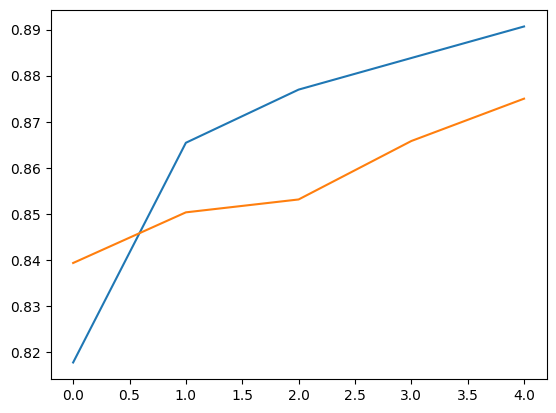

In [20]:
plt.plot(historial.history['accuracy'])
plt.plot(historial.history['val_accuracy'])
plt.show()

1/1 [==============================] - 0s 16ms/step


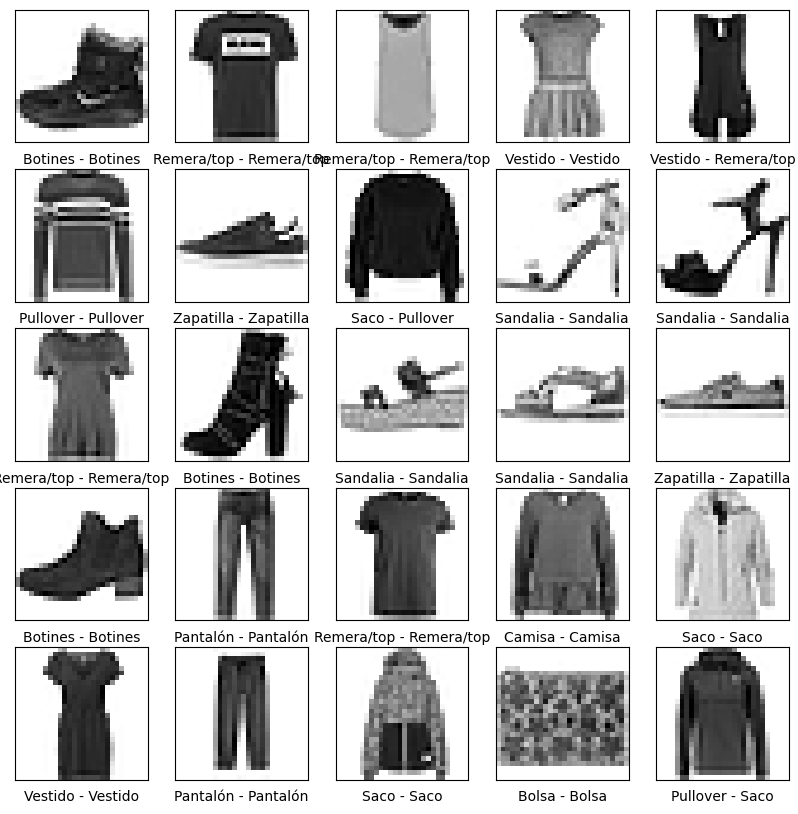

In [21]:
# Veamoslo en acción!

import numpy as np

plt.figure(figsize=(ANCHO*2, ALTO*2))

for i, (imagen, etiqueta) in enumerate(zip(x_train, y_train), start=1):
  if i > ANCHO * ALTO:
    break
  
  plt.subplot(ALTO, ANCHO, i)
  plt.xticks([])
  plt.yticks([])

  prediccion_vector = modelo.predict(np.array([imagen]))
  prediccion = etiquetas[np.argmax(prediccion_vector)]
  verdad = etiquetas[np.argmax(etiqueta)]
  plt.xlabel(f"{prediccion} - {verdad}")
  plt.imshow(imagen.reshape((28,28)), cmap='gray_r')

In [22]:
# Aumento de datos
# Acá definimos qué tipo de transformaciones le queremos aplicar a nuestras imágenes
# Pueden ver todas las trasnformaciones acá:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

entrenamiento_aumentado = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
)

entrenamiento_aumentado.fit(x_train)
entrenamiento_aumentado

1/1 [==============================] - 0s 20ms/step


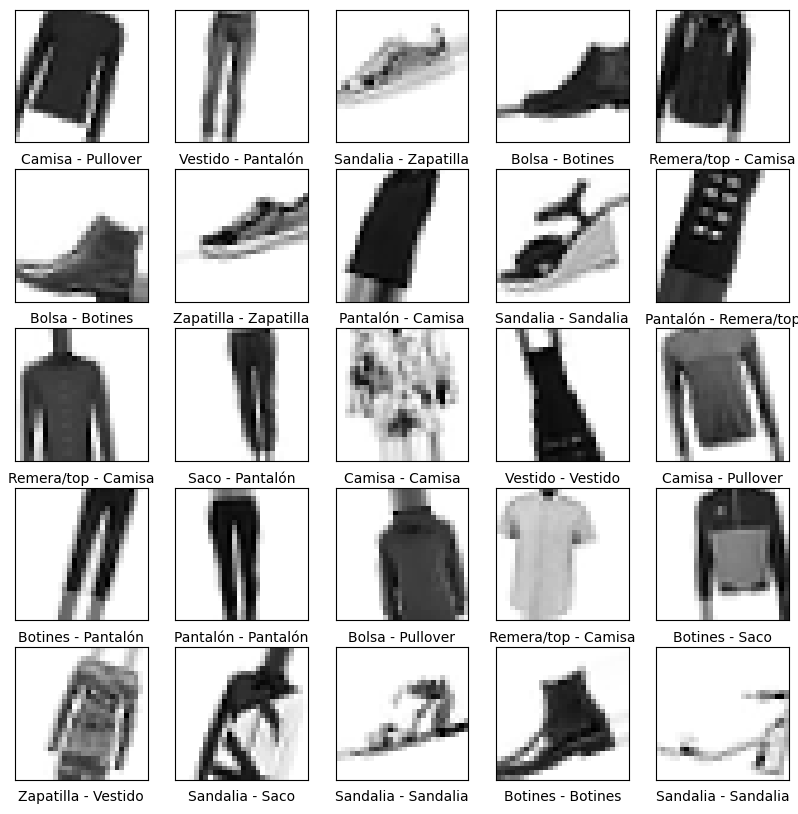

In [23]:
# Hacemos un generador de imagenes transformadas
# También nos lo divide en tandas (batch). Le especificamos el tamaño
generador = entrenamiento_aumentado.flow(x_train, y_train, batch_size=TOTAL)

# Sacamos un batch (=25 Imagenes) transformadas
x_batch, y_batch = next(generador)

plt.figure(figsize=(ANCHO*2, ALTO*2))

for i, (imagen, etiqueta) in enumerate(zip(x_batch, y_batch), start=1):
  if i > ANCHO * ALTO:
    break
  
  plt.subplot(ALTO, ANCHO, i)
  plt.xticks([])
  plt.yticks([])

  imagen = imagen
  prediccion_vector = modelo.predict(np.array([imagen]))
  prediccion = etiquetas[np.argmax(prediccion_vector)]
  verdad = etiquetas[np.argmax(etiqueta)]
  plt.xlabel(f"{prediccion} - {verdad}")
  plt.imshow(imagen.reshape((28,28)), cmap='gray_r')